In [1]:
import os, sys
print(sys.executable) # works this time
print(sys.version)
print(sys.version_info)
import scanpy as sc
from sklearn.cross_decomposition import CCA
from sklearn.manifold import TSNE
from scipy.sparse import csr_matrix
from scipy.sparse import csr_matrix
import numpy as np
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import random

I:\mutiomics\pythonProject\.venv\Scripts\python.exe
3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0)


In [4]:

adata1 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11T16-085\\V11T16-085_B1\\output_data\\V11T16-085_B1_MSI\\V11T17-085_B1.Visium.FMP.220826_smamsi.h5ad")
adata2 = sc.read_h5ad("I:\\mutiomics\\Spatial Multimodal Analysis of Transcriptomes and Metabolomes in Tissues\\sma\\sma\\V11T16-085\\V11T16-085_D1\\output_data\\V11T16-085_D1\\outs\\V11T16-085_D1.h5ad")

In [5]:
adata1.obs["leiden"] = adata1.obs["clusters"]
adata2.obs["leiden"] = adata2.obs["clusters"]
idx_to_remove = adata1.obs["clusters"][adata1.obs["clusters"] == "0"]
keep_cells_mask = ~adata1.obs.index.isin(idx_to_remove.index)
adata1 = adata1[keep_cells_mask, :]
print(adata2)
print(adata1)
print(idx_to_remove.index)

AnnData object with n_obs × n_vars = 1366 × 14442
    obs: 'in_tissue', 'array_row', 'array_col', 'mt_frac', 'total_counts', 'n_counts', 'n_genes', 'clusters', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 4130 × 1538
    obs: 'clusters', 'leiden'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '7646', '7647', '7648', '7649', '7650', '7651', '7652', '7653', '7654',
       '7655'],
      dtype='object', 

In [6]:
data1_pca_results = adata1.obsm['spatial']  # PCA 结果
pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()

data2_pca_results = adata2.obsm['X_umap']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()

def var_select(df, m1, m2, n):
    # 1. 筛选出列均值在 m1 和 m2 之间的行
    filtered_df = df.loc[:,(df.mean() > m1) & (df.mean() < m2)]

    # 2. 计算每行的方差，并选择前 n 个最大值所对应的索引
    variances = filtered_df.var(axis=0)/filtered_df.mean()
    sorted_indices = variances.sort_values(ascending=False).index
    selected_indices = sorted_indices[:n]

    return selected_indices.tolist()


def convert_to_array(x):
    if isinstance(x, csr_matrix):
        return x.toarray()
    elif isinstance(x, np.ndarray):
        return x
    else:
        raise ValueError("Unsupported input type. Must be csr_matrix or ndarray.")
        
def tpm_normalize(counts_matrix):
    # 计算每个细胞的总表达量
    total_counts_per_cell = counts_matrix.sum(axis=1)
    # 计算每个基因的 TPM
    tpm_matrix = (counts_matrix.div(total_counts_per_cell, axis=0)) * 1e4
    return tpm_matrix

In [12]:
##first select random 2200 indices
selected_indices = np.random.choice(4130, 1366, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 1] = 10
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [10])] = 11
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 1] = 10
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [10])] = 11

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 10
X2_label[X2_label == 2] = 10
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [10])] = 11

[10 10 10 ... 10 11 11]


In [16]:
#####spatial alignment of data3(metabolic) and data2(spatial) using CCA
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})

def flip_around_y_plus_x(row):
    new_x = row[1]
    new_y = row[0]
    return pd.Series({0: new_x, 1: new_y})

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
#data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
#data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)


<bound method NDFrame.head of              0         1
0    -1.000000  0.310345
1    -1.000000  0.333333
2    -1.000000  0.356322
3    -1.000000  0.379310
4    -1.000000  0.402299
...        ...       ...
4125  0.976744 -0.632184
4126  0.976744 -0.609195
4127  1.000000 -0.724138
4128  1.000000 -0.701149
4129  1.000000 -0.678161

[4130 rows x 2 columns]>
<bound method NDFrame.head of              0         1
2905  0.279070  0.057471
327  -0.744186  0.540230
1340 -0.302326 -0.425287
2042 -0.046512 -0.264368
2147 -0.023256  0.701149
...        ...       ...
1645 -0.209302  0.885057
3379  0.488372 -0.885057
3786  0.674419 -0.333333
256  -0.790698  0.724138
732  -0.558140  0.724138

[1366 rows x 2 columns]>


In [18]:
cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
data1_spatial_results = cca.transform(data1_spatial_results)
data2_spatial_results = cca.transform(data2_spatial_results)
data3_spatial_results = cca.transform(data3_spatial_results)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)

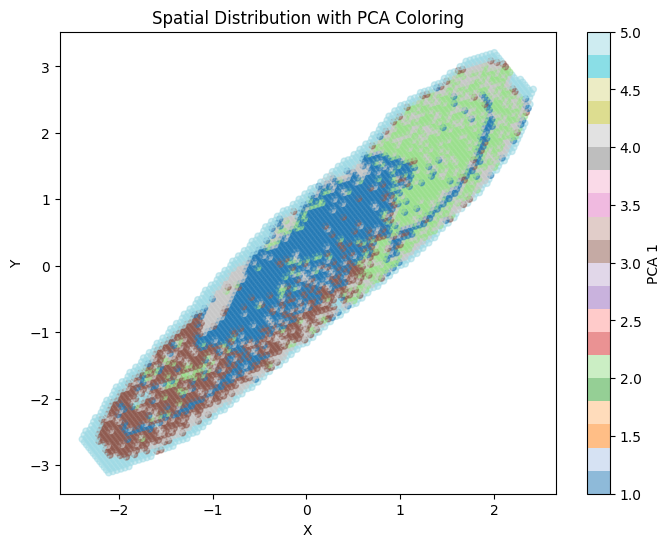

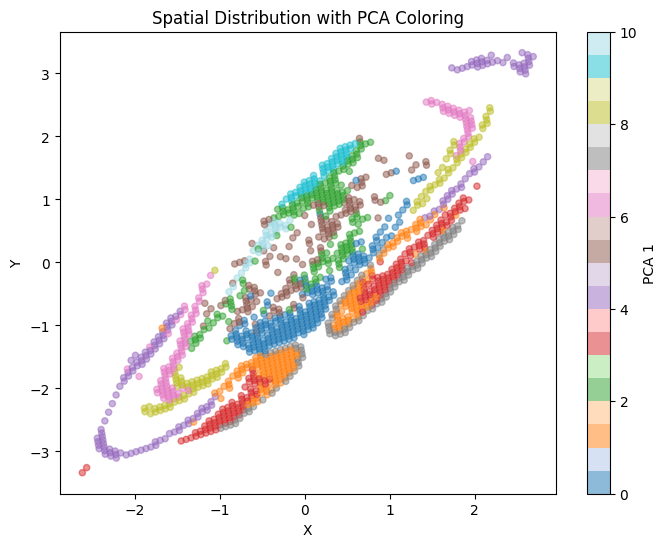

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [20]:
##############select nearst indices in UMAP
import random
selected_indices = np.random.choice(31185, 3734, replace=False)
selected_indices = np.random.choice(3084, 2220, replace=False)
def func1(selected_indices):
    X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
    X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
    X1_label[X1_label == 1] = 10
    # 将除了12和13之外的所有值都替换为100
    X1_label[~np.isin(X1_label, [10])] = 11
    print(X1_label)
    X3_label = adata1.obs["leiden"].to_numpy().astype(int)
    X3_label[X3_label == 1] = 10
    # 将除了12和13之外的所有值都替换为100
    X3_label[~np.isin(X3_label, [10])] = 11

    X2_label = adata2.obs["leiden"].to_numpy().astype(int)
    X2_label[X2_label == 0] = 10
    X2_label[X2_label == 2] = 10
    # 将除了12和13之外的所有值都替换为100
    X2_label[~np.isin(X2_label, [10])] = 11
    # 将除了12和13之外的所有值都替换为100
    X2_label[~np.isin(X2_label, [10,11])] = 12

    scaler = MinMaxScaler(feature_range=(-1, 1))

    data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
    scaled_data = scaler.fit_transform(data3_spatial_results)
    data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
    data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
    data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
    scaled_data = scaler.fit_transform(data2_spatial_results)
    data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
    data1_spatial_results=pd.DataFrame(data1_spatial_results)
    data2_spatial_results=pd.DataFrame(data2_spatial_results)
    data3_spatial_results=pd.DataFrame(data3_spatial_results)
    data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
    data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
    data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)

    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_data3 = convert_to_array(adata1.X)
    X_data3 = pd.DataFrame(X_data3)
    X_data3 = scaler.fit_transform(X_data3)
    X_data3 = pd.DataFrame(X_data3)
    high_variance_variables = var_select(X_data3,-100,4000000, 500)
    X_data3 = X_data3.iloc[:,high_variance_variables]
    pca = PCA()
# 对数据进行 PCA
    X3_pca = pca.fit_transform(X_data3)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
    scaled_data = scaler.fit_transform(X_3_umap_results)
    X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
    X_3_umap_results[2] = X3_label
    X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
    X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
    #X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

    X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


    X_data2 = convert_to_array(adata2.X)
    X_data2 = pd.DataFrame(X_data2)
    X_data2 = tpm_normalize(X_data2)
    X_data2 = np.log2(X_data2 + 1)
    X_data2 = pd.DataFrame(X_data2)
    high_variance_variables = var_select(X_data2,0.01,40 ,2000)
    X_data2 = X_data2.iloc[:,high_variance_variables]
    #X_data2 = scaler.fit_transform(X_data2)
    pca = PCA()
    # 对数据进行 PCA
    X2_pca = pca.fit_transform(X_data2)
    umap_model = umap.UMAP(n_components=2, random_state=42)
    X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
    #X_2_umap_results = pd.DataFrame(adata2.obsm["X_umap"])
    scaled_data = scaler.fit_transform(X_2_umap_results)
    X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
    #X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
    X_2_umap_results[2] = X2_label
    X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
    X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
    cca = CCA(n_components=2)
    cca.fit(X_1_umap_results,X_2_umap_results)
    X_c = cca.transform(X_1_umap_results)
    Y_c = cca.transform(X_2_umap_results)
    Z_c = cca.transform(X_3_umap_results)

    X_c=pd.DataFrame(X_c)
    Y_c=pd.DataFrame(Y_c)
    Z_c=pd.DataFrame(Z_c)

    dist_min = 0.05 ## min euclidean distance
    from scipy.spatial.distance import cdist
    distances = cdist(Z_c, Y_c, metric='euclidean')
    dist_df = pd.DataFrame(distances)
    dt_describe = dist_df.describe()
    ###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
    row_indices, col_indices = np.where(distances <dist_min)
    unique_row_indices = np.unique(row_indices)
    return unique_row_indices

def sample_and_apply(input_array,n,m):
    m = m
    output_array = []
    elements = list(input_array)  # 生成包含所有元素的列表
    
    while m > -1:  # 当列表不为空时循环
        random.shuffle(elements)  # 随机洗牌
        sample = elements[:n]  # 从列表中随机抽取 n 个元素
        output_array.append(func1(sample))  # 将输出值存储在新数组中
        m = m-1
    return output_array
output_array = sample_and_apply(range(3084), 2220,-1)
print("select indice finished")


select indice finished


In [21]:
print(len(output_array))
array_lengths = [len(arr) for arr in output_array]
# 打印每个数组的长度
for i, length in enumerate(array_lengths):
    print("Length of array", i+1, ":", length)
merged_array = np.concatenate(output_array)
merged_array = np.unique(merged_array)
print(len(merged_array))

0


ValueError: need at least one array to concatenate

In [22]:
###casual run using neasrst indices
selected_indices = np.random.choice(range(4130), 1366, replace=False)
X1_label=adata1.obs["leiden"].to_numpy()[selected_indices].astype(int)
X1_label[X1_label == 1] = 10
# 将除了12和13之外的所有值都替换为100
X1_label[~np.isin(X1_label, [10])] = 11
print(X1_label)
X3_label = adata1.obs["leiden"].to_numpy().astype(int)
X3_label[X3_label == 1] = 10
# 将除了12和13之外的所有值都替换为100
X3_label[~np.isin(X3_label, [10])] = 11

X2_label = adata2.obs["leiden"].to_numpy().astype(int)
X2_label[X2_label == 0] = 10
X2_label[X2_label == 2] = 10
# 将除了12和13之外的所有值都替换为100
X2_label[~np.isin(X2_label, [10])] = 11

[11 11 10 ... 11 11 11]


In [24]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data3_spatial_results = data3_spatial_results.apply(flip_around_y_plus_x, axis=1)

<bound method NDFrame.head of              0         1
0    -1.000000  0.310345
1    -1.000000  0.333333
2    -1.000000  0.356322
3    -1.000000  0.379310
4    -1.000000  0.402299
...        ...       ...
4125  0.976744 -0.632184
4126  0.976744 -0.609195
4127  1.000000 -0.724138
4128  1.000000 -0.701149
4129  1.000000 -0.678161

[4130 rows x 2 columns]>
<bound method NDFrame.head of              0         1
3561  0.558140 -0.218391
2087 -0.023256 -0.678161
2592  0.162791 -0.218391
3378  0.488372 -0.908046
3726  0.651163 -0.724138
...        ...       ...
2466  0.116279 -0.333333
4107  0.930233 -0.448276
674  -0.581395  0.678161
4001  0.813953 -0.333333
4025  0.837209 -0.402299

[1366 rows x 2 columns]>


In [13]:
cca = CCA(n_components=2)
cca.fit(data1_spatial_results,data2_spatial_results)
data1_spatial_results = cca.transform(data1_spatial_results)
data2_spatial_results = cca.transform(data2_spatial_results)
data3_spatial_results = cca.transform(data3_spatial_results)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)

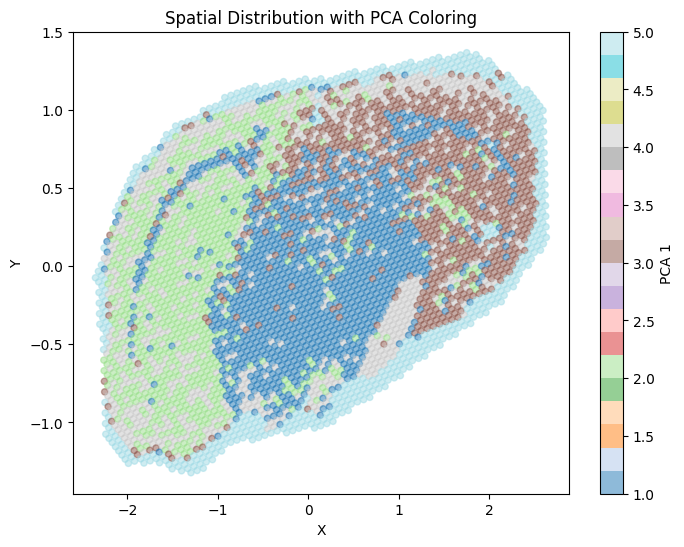

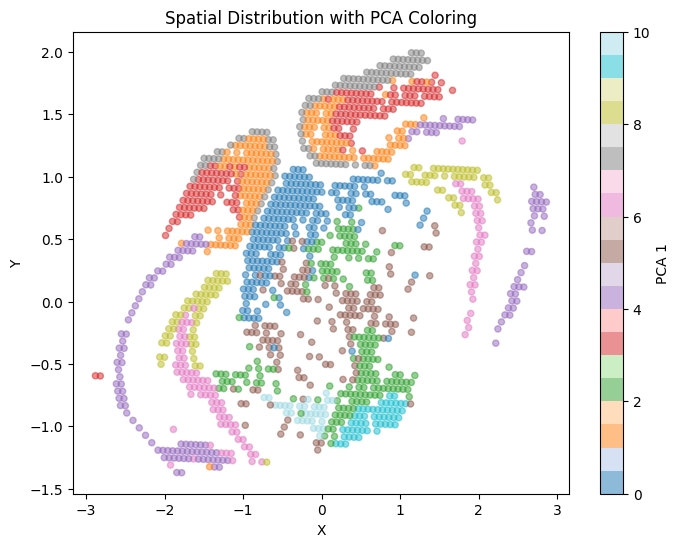

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=data1_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

In [15]:
#####X1:metabolic subgroup 
#####X2:spatial 
#####X3:metabolic whole group
#####normalize, pca and umap of X1,X2 and X3
#####perform CCA between X1 and X2
#####fit CCA model to X1 X2 X3



pca_leiden = adata1.obs["leiden"]
data1_leiden_str = pca_leiden.to_numpy()
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))

#print(X_1_umap_results.head)
print(pd.DataFrame(adata1.obsm['spatial']).iloc[selected_indices,0])
X_data3 = convert_to_array(adata1.X)
X_data3 = pd.DataFrame(X_data3)
X_data3 = scaler.fit_transform(X_data3)
X_data3 = pd.DataFrame(X_data3)
high_variance_variables = var_select(X_data3,-100,40000, 500)
X_data3 = X_data3.iloc[:,high_variance_variables]
pca = PCA()
# 对数据进行 PCA
X3_pca = pca.fit_transform(X_data3)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_3_umap_results = pd.DataFrame(umap_model.fit_transform(X3_pca))
scaled_data = scaler.fit_transform(X_3_umap_results)
X_3_umap_results = pd.DataFrame(scaled_data, columns=X_3_umap_results.columns)
X_3_umap_results[2] = X3_label
X_3_umap_results[3] = pd.DataFrame(data3_spatial_results).iloc[:,0].to_numpy()
X_3_umap_results[4] = pd.DataFrame(data3_spatial_results).iloc[:,1].to_numpy()
#X3_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X3_pca[:,0:30])

X_1_umap_results = X_3_umap_results.iloc[selected_indices,]


X_data2 = convert_to_array(adata2.X)
X_data2 = pd.DataFrame(X_data2)
X_data2 = tpm_normalize(X_data2)
X_data2 = np.log2(X_data2 + 1)
X_data2 = pd.DataFrame(X_data2)
high_variance_variables = var_select(X_data2,0.01,40 ,2000)
X_data2 = X_data2.iloc[:,high_variance_variables]
#X_data2 = scaler.fit_transform(X_data2)
pca = PCA()
# 对数据进行 PCA
X2_pca = pca.fit_transform(X_data2)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2_umap_results = pd.DataFrame(umap_model.fit_transform(X2_pca[:, 0:30]))
#X_2_umap_results = pd.DataFrame(adata2.obsm["X_umap"])
scaled_data = scaler.fit_transform(X_2_umap_results)
X_2_umap_results = pd.DataFrame(scaled_data, columns=X_2_umap_results.columns)
#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
X_2_umap_results[2] = X2_label
X_2_umap_results[3] = pd.DataFrame(data2_spatial_results).iloc[:,0].to_numpy()
X_2_umap_results[4] = pd.DataFrame(data2_spatial_results).iloc[:,1].to_numpy()
cca = CCA(n_components=2)
cca.fit(X_1_umap_results,X_2_umap_results)
X_c = cca.transform(X_1_umap_results)
Y_c = cca.transform(X_2_umap_results)
Z_c = cca.transform(X_3_umap_results)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

2098    42
1628    34
432     14
646     18
453     14
        ..
1995    40
1987    40
434     14
1225    28
3071    58
Name: 0, Length: 1366, dtype: int64


I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
I:\mutiomics\pythonProject\.venv\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


I:\mutiomics\pythonProject\.venv\lib\site-packages\matplotlib\collections.py:1109: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1366, 2)


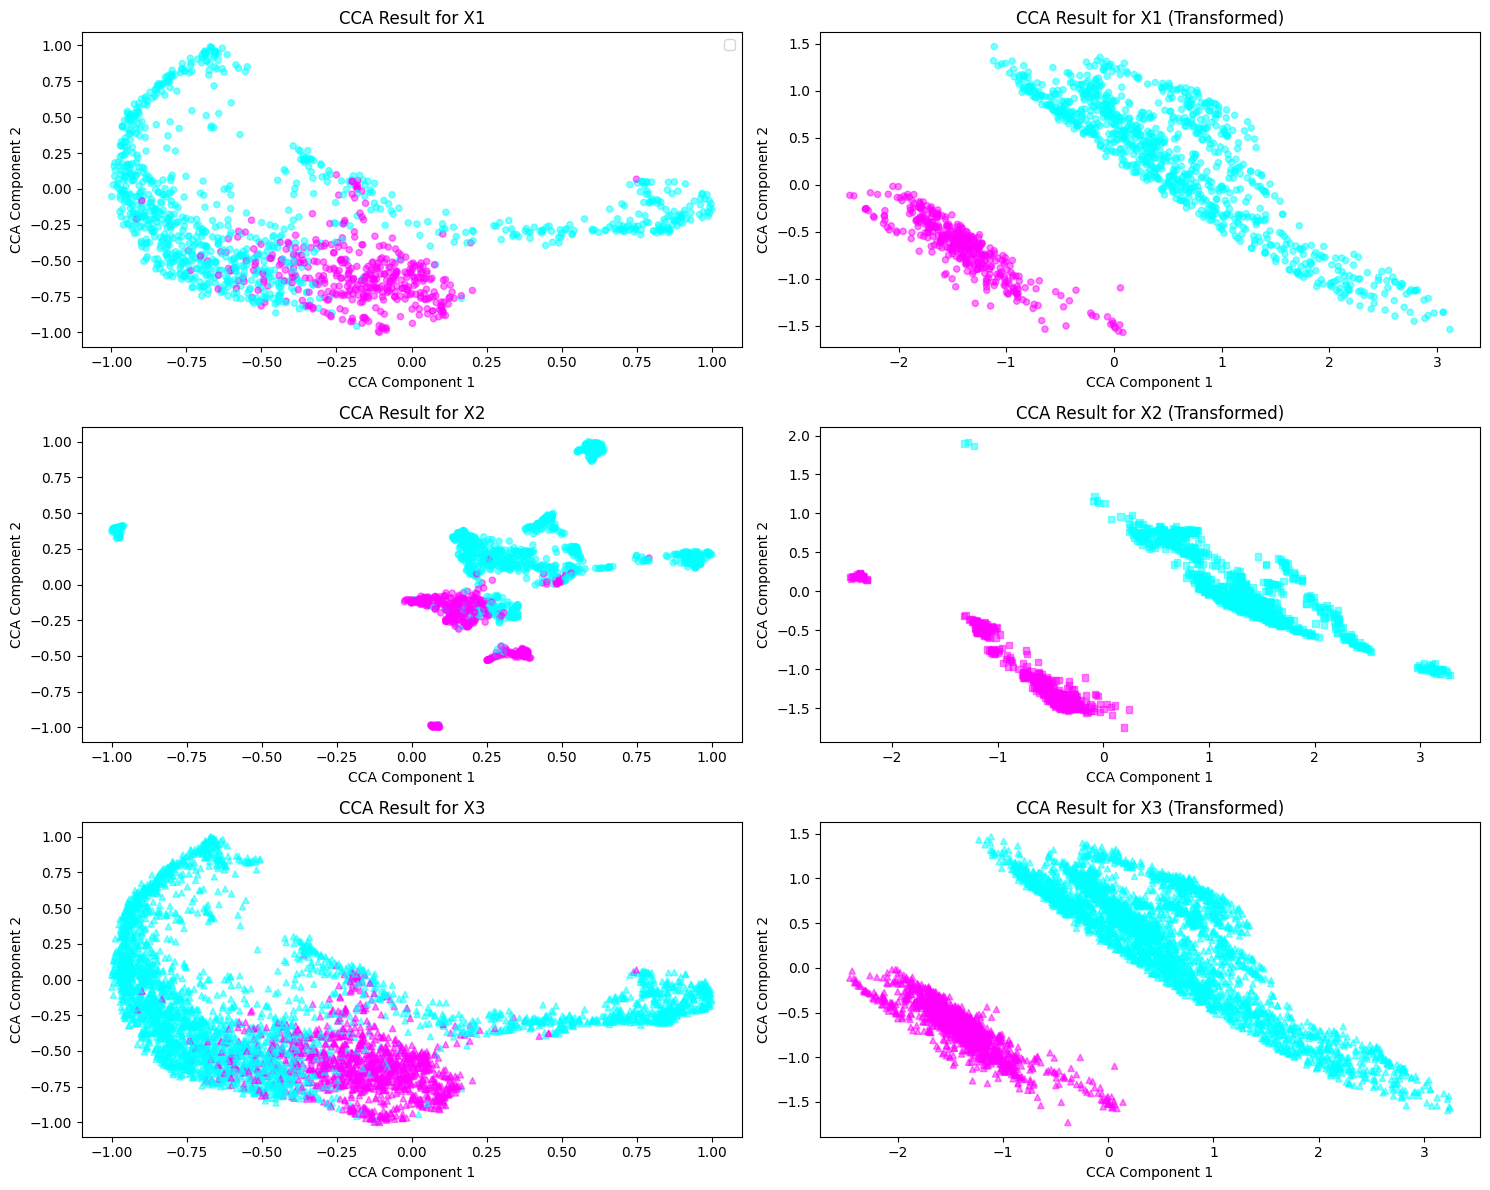

In [16]:
print(X_c.shape)
import matplotlib.pyplot as plt


#X2_tsne = TSNE(n_components=3,perplexity=10, random_state=42).fit_transform(X2_pca[:,0:30])
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'cyan',
    12: 'blue',
    13: 'red',
    14: 'green',
    15: 'yellow'
}

# 假设 X_c 和 Y_c 是 CCA 转换后的结果
# 在这个示例中，假设 X_c 和 Y_c 都是二维数据

plt.figure(figsize=(15, 12))

# 绘制 X1 的散点图
plt.subplot(3, 2, 1)
scatter = plt.scatter(X_1_umap_results.iloc[:, 0], X_1_umap_results.iloc[:, 1],
                     # c=[color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)],
                      c=[color_mapping[category] for category in X1_label],
                      s=20, alpha=0.5)
unique_categories = np.unique(data1_leiden_str[selected_indices].astype(int))
legend_labels = [f'Category {cat}' for cat in unique_categories]
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)
plt.title('CCA Result for X1')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')


# 绘制 X1 转换后的散点图
plt.subplot(3, 2, 2)
plt.scatter(X_c.iloc[:, 0], X_c.iloc[:, 1], 
          #  c= [color_mapping[category] for category in data1_leiden_str[selected_indices].astype(int)], 
            c= [color_mapping[category] for category in X1_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X1 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 的散点图
plt.subplot(3, 2, 3)
plt.scatter(X_2_umap_results.iloc[:, 0], X_2_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data2_leiden_str.astype(int)],
            c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5)
plt.title('CCA Result for X2')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X2 转换后的散点图
plt.subplot(3, 2, 4)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], 
             c= [color_mapping[category] for category in X2_label],
            s=20, alpha=0.5, marker='s')
plt.title('CCA Result for X2 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 的散点图
plt.subplot(3, 2, 5)
plt.scatter(X_3_umap_results.iloc[:, 0], X_3_umap_results.iloc[:, 1], 
           # c=[color_mapping[category] for category in data1_leiden_str.astype(int)],
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

# 绘制 X3 转换后的散点图
plt.subplot(3, 2, 6)
plt.scatter(Z_c.iloc[:, 0], Z_c.iloc[:, 1], 
          #  c=[color_mapping[category] for category in data1_leiden_str.astype(int)] , 
             c= [color_mapping[category] for category in X3_label],
            s=20, alpha=0.5, marker='^')
plt.title('CCA Result for X3 (Transformed)')
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')

plt.tight_layout()
plt.show()

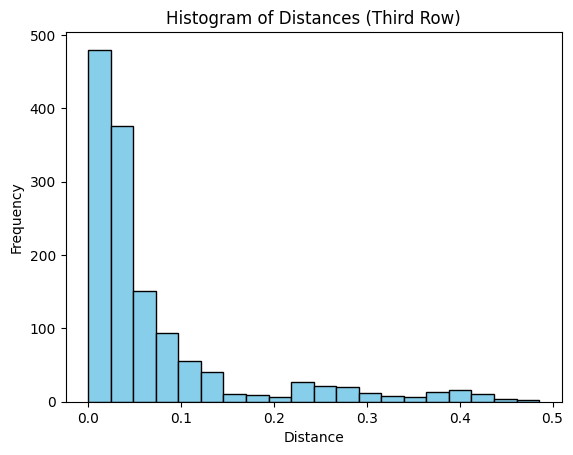

C:\Users\28123\AppData\Local\Temp\ipykernel_9540\3397104268.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_C_['spatial_ID'] = Y_C_.index
C:\Users\28123\AppData\Local\Temp\ipykernel_9540\3397104268.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(60986,) (60986,)
(1737,)
(1218,)
            0         1
22   0.273616  0.980063
52   0.074999  0.926907
69   0.281626  0.848664
367  0.313969  0.753844
585  0.238737  0.938564
         0        1
0  0.14743  0.85725
0  0.14743  0.85725
0  0.14743  0.85725
0  0.14743  0.85725
0  0.14743  0.85725
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z
0       0.273616       0.980063          22                5             -1
1       0.074999       0.926907          52                5             -1
2       0.281626       0.848664          69                5             -1
3       0.313969       0.753844         367                5             -1
4       0.238737       0.938564         585                5             -1
   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0          0.14743          0.85725             0                  5   
1          0.14743          0.85725             0                  5   
2          0.14743          0.

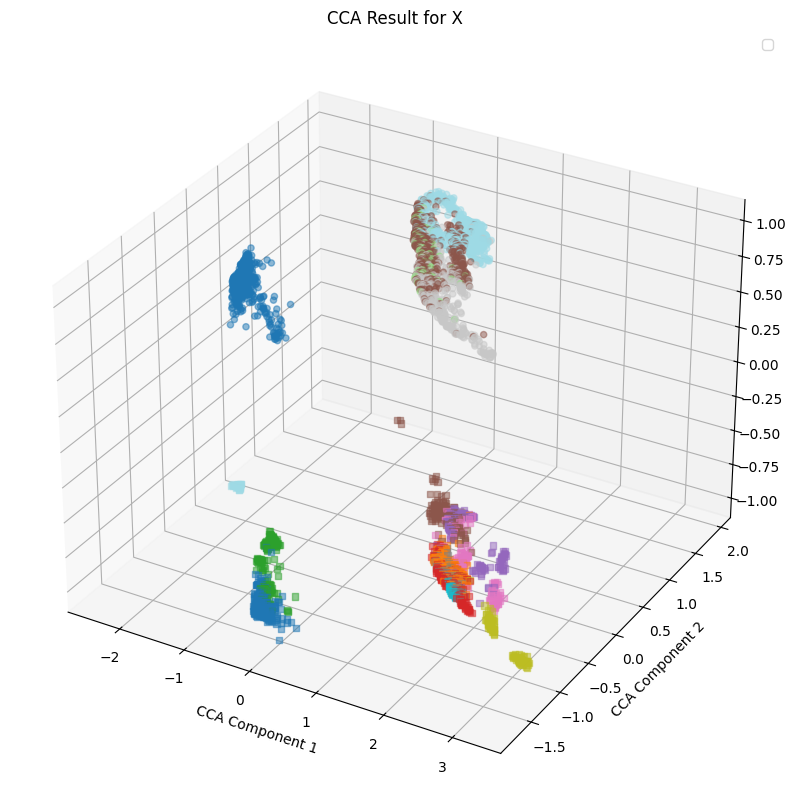

In [17]:
####select nearst neighbour groups of sample pairs between X1 and X3
####
dist_min = 0.2 ## min euclidean distance
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
dt_describe = dist_df.describe()
plt.hist(dt_describe.iloc[3,], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances (Third Row)')
plt.show()
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
row_indices, col_indices = np.where(distances <dist_min)
unique_row_indices = np.unique(row_indices)
unique_col_indices = np.unique(col_indices)
#############plot
####Z_C is metablic and is at 1
print(row_indices.shape, col_indices.shape)
print(unique_row_indices.shape)
print(unique_col_indices.shape)
print(Y_c.iloc[col_indices,].head())
print(Z_c.iloc[row_indices,].head())
Y_C_=Y_c.iloc[col_indices,]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_=Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str[col_indices].astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_=Y_C_.drop(columns=['index'])
Y_C_=Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})

Z_C_=Z_c.iloc[row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})

print(Y_C_.head())
print(Z_C_.head())
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()


In [18]:
import pandas as pd

def calculate_simpson_index(values):
    total_count = len(values)
    unique_values = set(values)
    simpson_index = 1 - sum((values.count(value) / total_count) ** 2 for value in unique_values)
    return simpson_index

def main(df):
    # 保存每个 X1 中值对应的 X2 中值的列表
    x1_x2_lists = df.groupby('spatial_ID')['matabolic_cluster'].apply(list).reset_index()

    # 计算每个 X1 中值的辛普森指数
    simpson_indices = x1_x2_lists['matabolic_cluster'].apply(calculate_simpson_index)

    # 保存每个 X1 中值对应的 X2 中出现频率最高的值
    max_x2_values = x1_x2_lists['matabolic_cluster'].apply(lambda x: max(set(x), key=x.count))

    # 生成新的 DataFrame
    new_df = pd.DataFrame({'spatial_ID': x1_x2_lists['spatial_ID'], 'Most_freq_metabolic_cluster': max_x2_values, 'Simpson_Index': simpson_indices})

    # 合并 X3 列
    new_df = pd.merge(new_df, df[['spatial_ID',"spatial_cluster"]].drop_duplicates(), on='spatial_ID', how='left')

    return new_df

# 示例输入数据
data = pairs
df = pd.DataFrame(data)

# 调用主函数
result_df = main(df)
print("新的 DataFrame:")
print(result_df)


新的 DataFrame:
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  spatial_cluster
0              0                            1       0.000000                2
1              1                            5       0.509166                6
2              2                            4       0.292160                3
3              3                            1       0.000000                2
4              5                            5       0.512617                4
...          ...                          ...            ...              ...
1213        1361                            4       0.356518                1
1214        1362                            1       0.000000                0
1215        1363                            1       0.000000                2
1216        1364                            5       0.380928                5
1217        1365                            1       0.000000                0

[1218 rows x 4 columns]


<bound method NDFrame.head of              0         1
0    -1.000000  0.310345
1    -1.000000  0.333333
2    -1.000000  0.356322
3    -1.000000  0.379310
4    -1.000000  0.402299
...        ...       ...
4125  0.976744 -0.632184
4126  0.976744 -0.609195
4127  1.000000 -0.724138
4128  1.000000 -0.701149
4129  1.000000 -0.678161

[4130 rows x 2 columns]>
<bound method NDFrame.head of              0         1
2098 -0.023256 -0.425287
1628 -0.209302  0.494253
432  -0.674419 -0.149425
646  -0.581395  0.034483
453  -0.674419  0.333333
...        ...       ...
1995 -0.069767  0.126437
1987 -0.069767 -0.057471
434  -0.674419 -0.103448
1225 -0.348837 -0.264368
3071  0.348837 -0.195402

[1366 rows x 2 columns]>


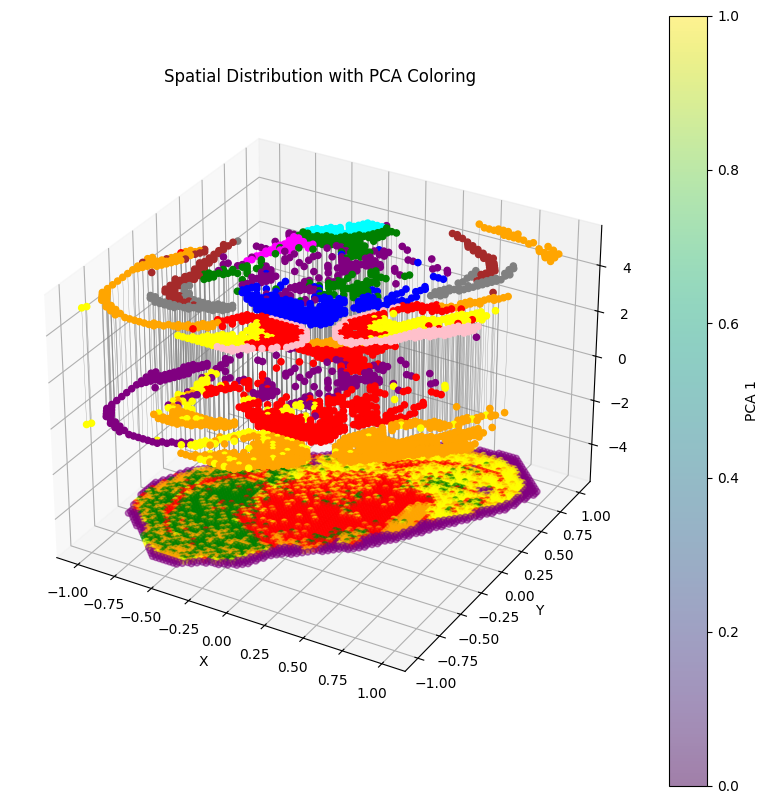

In [19]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data2_pca_results = adata2.obsm['spatial']
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1], zs=0,
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in result_df["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

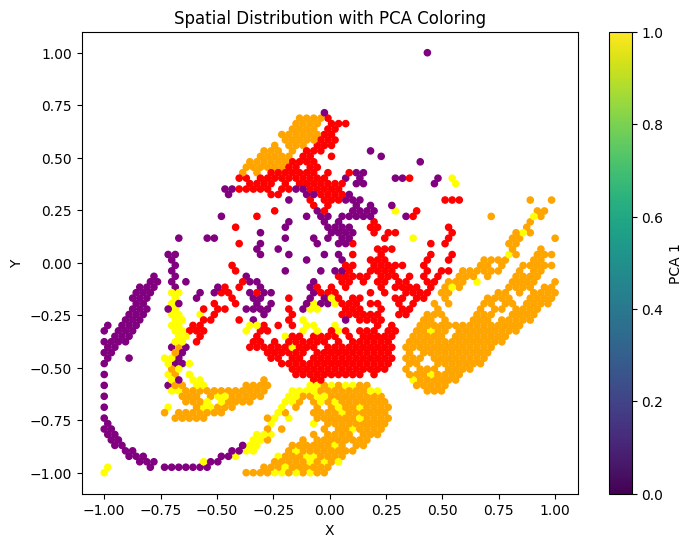

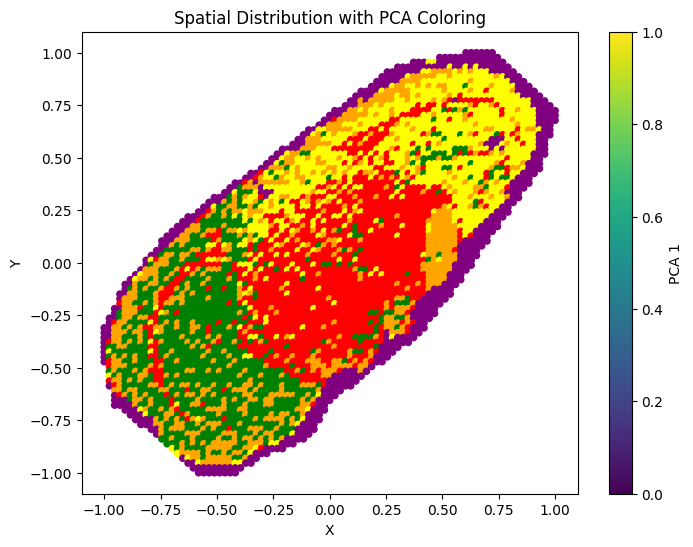

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 0],data2_spatial_results.iloc[result_df[result_df["Simpson_Index"]<1.1]["spatial_ID"].tolist(), 1],
            c=[color_mapping[category] for category in result_df[result_df["Simpson_Index"]<1]["Most_freq_metabolic_cluster"].tolist()], s=20, alpha=1)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

C:\Users\28123\AppData\Local\Temp\ipykernel_9540\318621266.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data1_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)


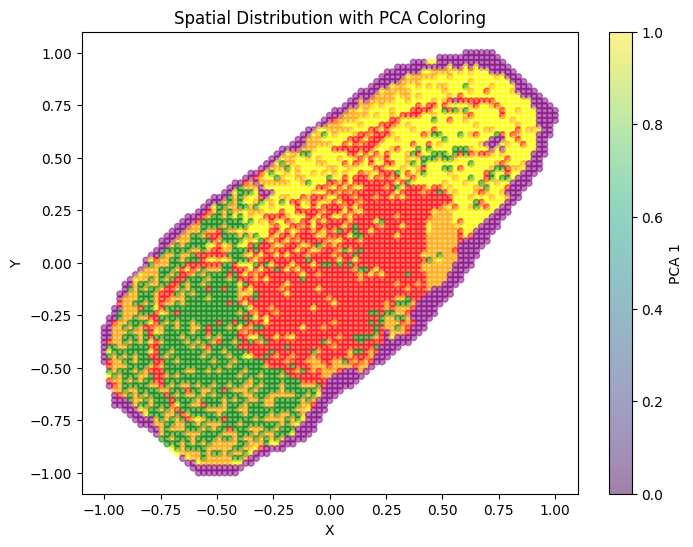

C:\Users\28123\AppData\Local\Temp\ipykernel_9540\318621266.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)


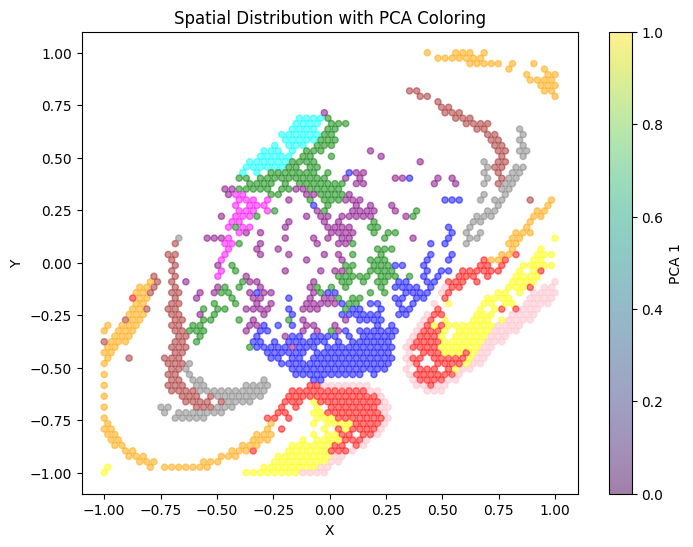

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data1_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1],  c=[color_mapping[category] for category in data2_leiden_str.astype(int)], cmap='tab20', s=20, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

C:\Users\28123\AppData\Local\Temp\ipykernel_9540\808405300.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4130, 2) (1366, 2)
(4130, 1366)
(4130, 2) (1366, 2)
(4130, 2) (1366, 2)
   spatial.CCA.X  spatial.CCA.Y  spatial_ID  spatial_cluster  spatial.CCA.Z  \
0      -1.220062      -0.389843           0                2             -1   
1       0.787185       0.524160           1                6             -1   
2       1.279358      -0.210087           2                3             -1   
3      -0.516551      -1.233795           3                2             -1   
4       1.839887       0.144913           4                4             -1   

   metabolic.CCA.X  metabolic.CCA.Y  matabolic_ID  matabolic_cluster  \
0        -1.150004        -0.437980          2682                  1   
1         0.784274         0.519286          2983                  5   
2         1.249602        -0.167138          3689                  4   
3        -0.491382        -1.232118          2200                  1   
4         1.479727        -0.012078          4047                  4   

   matabolic.CCA.Z 

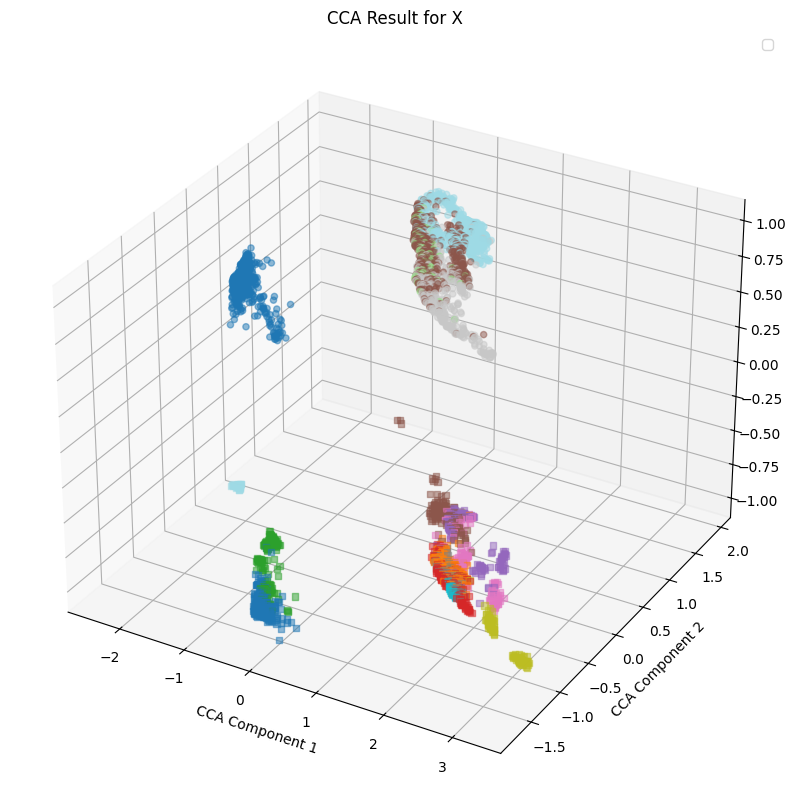

In [22]:
####select nearst neighbour of sample pairs between X1 and X3
####
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='euclidean')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

<bound method NDFrame.head of              0         1
0    -1.000000  0.310345
1    -1.000000  0.333333
2    -1.000000  0.356322
3    -1.000000  0.379310
4    -1.000000  0.402299
...        ...       ...
4125  0.976744 -0.632184
4126  0.976744 -0.609195
4127  1.000000 -0.724138
4128  1.000000 -0.701149
4129  1.000000 -0.678161

[4130 rows x 2 columns]>
<bound method NDFrame.head of              0         1
2098 -0.023256 -0.425287
1628 -0.209302  0.494253
432  -0.674419 -0.149425
646  -0.581395  0.034483
453  -0.674419  0.333333
...        ...       ...
1995 -0.069767  0.126437
1987 -0.069767 -0.057471
434  -0.674419 -0.103448
1225 -0.348837 -0.264368
3071  0.348837 -0.195402

[1366 rows x 2 columns]>


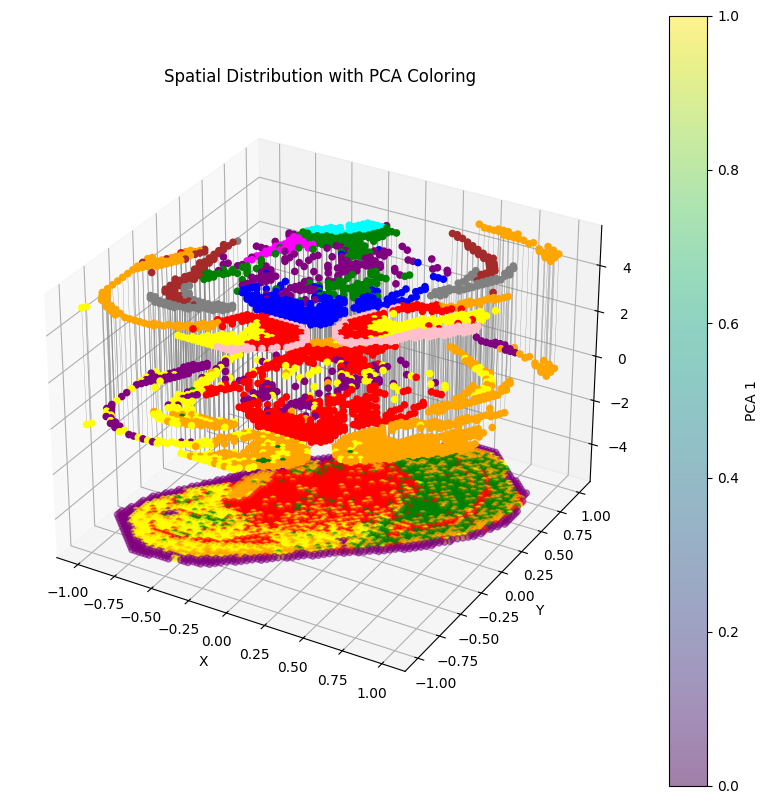

In [23]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
#data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data2_pca_results = adata2.obsm['spatial']
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], zs=0,
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in pairs["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

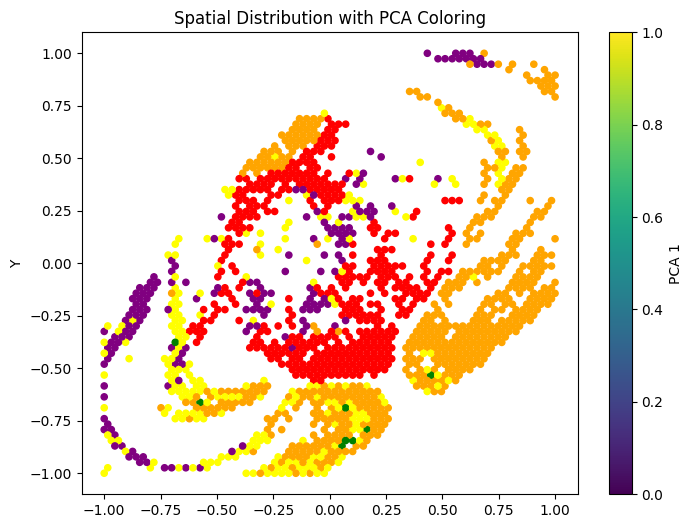

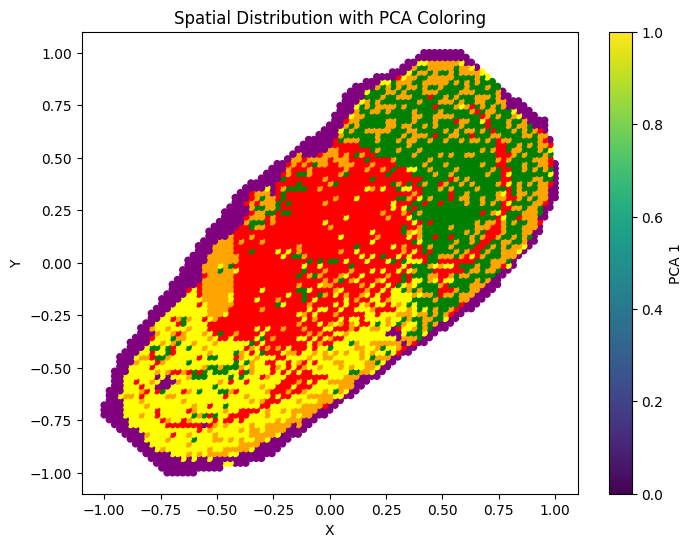

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

0          0
3          3
8          9
9         10
10        11
        ... 
1211    1359
1212    1360
1214    1362
1215    1363
1217    1365
Name: spatial_ID, Length: 401, dtype: int64
      spatial_ID  Most_freq_metabolic_cluster  Simpson_Index  \
0              0                            1            0.0   
3              3                            1            0.0   
8              9                            1            0.0   
9             10                            1            0.0   
10            11                            1            0.0   
...          ...                          ...            ...   
1211        1359                            1            0.0   
1212        1360                            1            0.0   
1214        1362                            1            0.0   
1215        1363                            1            0.0   
1217        1365                            1            0.0   

      spatial_cluster_x  spatial.CCA.X  spat

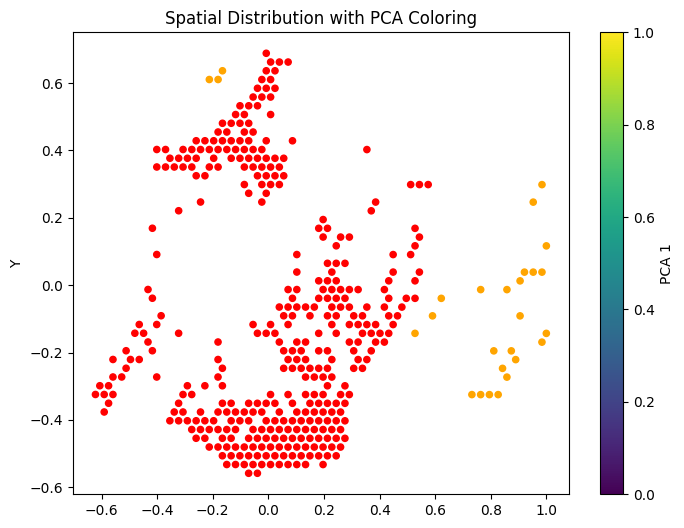

In [40]:
###### find transcript-metaboic pairs anchors by filtering: 
######1/simpson index less than 0.2 2/Most_freq_metabolic_cluster==matabolic_cluster
#print(result_df.head)
#print(pairs.head)
merged_df = pd.merge(result_df, pairs, on='spatial_ID', how='inner')
merged_df = pd.DataFrame(merged_df)
merged_df = merged_df[(merged_df['Simpson_Index'] < 0.01) & (merged_df['Most_freq_metabolic_cluster'] == merged_df['matabolic_cluster'])]
print(merged_df["spatial_ID"])
print(merged_df)
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[merged_df["spatial_ID"], 0],data2_spatial_results.iloc[merged_df["spatial_ID"], 1], 
            c=[color_mapping[category] for category in merged_df["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()


In [39]:
scaler = MinMaxScaler(feature_range=(-1, 1))
DF1 = convert_to_array(adata2.X)
DF1 = pd.DataFrame(DF1)
DF1 = tpm_normalize(DF1)
DF1 = np.log2(DF1 + 1)
DF1 = scaler.fit_transform(DF1)
DF1 = pd.DataFrame(DF1)

DF2 = convert_to_array(adata1.X)
DF2 = pd.DataFrame(DF2)
DF2 = scaler.fit_transform(DF2)
DF2 = pd.DataFrame(DF2)

print(DF1.shape,DF2.shape)
spatial_ID_list = merged_df['spatial_ID'].tolist()
metabolic_ID_list = merged_df['matabolic_ID'].tolist()

# 从 DF1 和 DF2 中提取对应的样本
spatial_samples = DF1.loc[spatial_ID_list,:]
index_strings = adata2.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(spatial_samples.columns, index_strings)}
spatial_samples.rename(columns=column_mapping, inplace=True)
rowindex = spatial_samples.shape[0]
spatial_samples.index = range(rowindex)

metabolic_samples = DF2.loc[metabolic_ID_list,:]
rowindex = metabolic_samples.shape[0]
index_strings = adata1.var.index.astype(str)
column_mapping = {old_name: new_name for old_name, new_name in zip(metabolic_samples.columns, index_strings)}
metabolic_samples.rename(columns=column_mapping, inplace=True)
metabolic_samples.index = range(rowindex)

print(spatial_samples.shape,metabolic_samples.shape,pd.concat([spatial_samples, metabolic_samples], axis=0).shape)
# 计算特征之间的相关性

(1366, 14442) (4130, 1538)
(401, 14442) (401, 1538) (802, 15980)


In [27]:
correlation_matrix = pd.concat([spatial_samples, metabolic_samples], axis=1)
correlation_matrix = correlation_matrix.corr()
# 显示相关性矩阵
print("DF1 列变量与 DF2 列变量之间的相关性矩阵：")
# 显示 DF3
#print(DF3)

DF1 列变量与 DF2 列变量之间的相关性矩阵：


(14442, 1538)


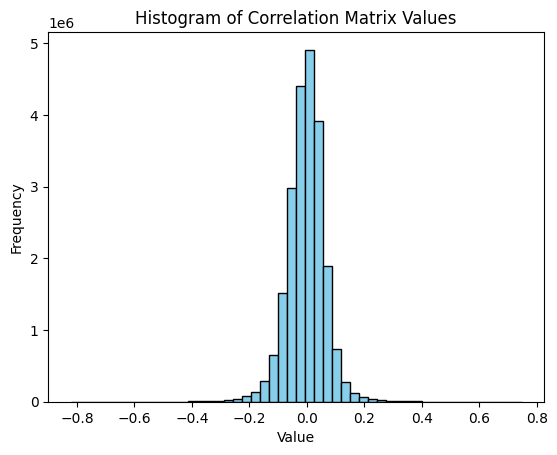

大于0.8的行：
13

大于0.8的列：
13
相关性大于0.8的值：
[8882, 8882, 8882, 8882, 8882, 8882, 8882, 8882, 8882, 8882, 10214, 10499, 11701]
13
156.26059     0.612929
156.26195    -0.865857
156.48344    -0.077188
156.4838     -0.256631
156.485      -0.870380
                ...   
1046.36442    0.737313
1048.32025    0.741373
1048.3319     0.650037
1048.34354   -0.943569
1048.38431    0.671064
Length: 1538, dtype: float64
[0, 45, 145, 472, 533, 562, 650, 1032, 1337, 1468, 962, 544, 962]


In [42]:
correlation_matrix2 = correlation_matrix.iloc[:14442, -1538:]
print(correlation_matrix2.shape)

values = correlation_matrix2.values.flatten()
plt.hist(values, bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Correlation Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# 显示图形
plt.show()
high_correlation_spatial = []
high_correlation_metabolic = []

# 遍历相关性矩阵的所有元素
indices = (correlation_matrix2 < 1) & (correlation_matrix2 > 0.65)
high_corr_indices = indices.values.nonzero()
# 将行和列索引分别存储到两个列表中
high_correlation_spatial = high_corr_indices[0].tolist()
high_correlation_metabolic = high_corr_indices[1].tolist()
#high_correlation_spatial = correlation_matrix2.index[correlation_matrix2.apply(lambda x: x > 0.8).any(axis=1)]
#high_correlation_spatial = set(high_correlation_spatial)
#high_correlation_metabolic = correlation_matrix2.columns[correlation_matrix2.apply(lambda x: x > 0.8).any(axis=0)]
#high_correlation_metabolic = set(high_correlation_metabolic)
# 显示满足条件的行和列
print("大于0.8的行：")
print(len(high_correlation_spatial))
print("\n大于0.8的列：")
print(len(high_correlation_metabolic))
# 显示满足条件的值
print("相关性大于0.8的值：")


column_means = spatial_samples.mean()
columns_to_remove = column_means[column_means < 0].index
filtered_high_correlation_spatial = [col for col in high_correlation_spatial if col not in columns_to_remove]
print(filtered_high_correlation_spatial)
print(len(filtered_high_correlation_spatial))
column_means = metabolic_samples.mean()
print(column_means)
columns_to_remove = column_means[column_means < -1].index
filtered_high_correlation_metabolic = [col for col in high_correlation_metabolic if col not in columns_to_remove]
print(filtered_high_correlation_metabolic)


In [43]:
scaler = MinMaxScaler(feature_range=(-1, 1))

metabolic_select_high_corr_variant = convert_to_array(adata1.X)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = scaler.fit_transform(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = pd.DataFrame(metabolic_select_high_corr_variant)
metabolic_select_high_corr_variant = metabolic_select_high_corr_variant.iloc[:,high_correlation_metabolic]
metabolic_select_high_corr_variant = pd.concat([X_3_umap_results, metabolic_select_high_corr_variant], axis=1)
print(metabolic_select_high_corr_variant.shape)
metabolic_select_high_corr_variant_X1 = metabolic_select_high_corr_variant.iloc[selected_indices,]

spatial_select_high_corr_variant = convert_to_array(adata2.X)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = scaler.fit_transform(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = pd.DataFrame(spatial_select_high_corr_variant)
spatial_select_high_corr_variant = spatial_select_high_corr_variant.iloc[:,high_correlation_spatial]
spatial_select_high_corr_variant = pd.concat([X_2_umap_results, spatial_select_high_corr_variant], axis=1)
print(spatial_select_high_corr_variant.shape)



(4130, 18)
(1366, 18)


In [44]:
cca = CCA(n_components=18)
cca.fit(spatial_select_high_corr_variant,metabolic_select_high_corr_variant_X1)
X_c = cca.transform(metabolic_select_high_corr_variant_X1)
Y_c = cca.transform(spatial_select_high_corr_variant)
Z_c = cca.transform(metabolic_select_high_corr_variant)

X_c=pd.DataFrame(X_c)
Y_c=pd.DataFrame(Y_c)
Z_c=pd.DataFrame(Z_c)

C:\Users\28123\AppData\Local\Temp\ipykernel_9540\1062708598.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Z_C_['matabolic_ID'] = Z_C_.index
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(4130, 18) (1366, 18)
(4130, 1366)
(4130, 18) (1366, 18)
(4130, 18) (1366, 18)
   spatial.CCA.X  spatial.CCA.Y         2         3         4         5  \
0      -0.510947      -0.623114 -0.713832  0.019381  0.023744 -0.335241   
1      -0.213506       0.264130  0.010128 -0.351985  0.457989  0.542212   
2       0.293317       0.163188  0.569958  0.016172  0.201713  0.326709   
3      -0.236806      -0.507896  0.102115  0.185609 -0.196569 -0.448549   
4      -0.107829       2.072643 -0.733368  0.569814  0.083774 -0.922205   

          6         7         8         9  ...        11        12        13  \
0 -0.170878 -0.041682  0.479439  0.495722  ... -0.208447 -0.144337 -0.654998   
1 -0.557636 -0.502627  0.167924  0.034878  ...  0.207749 -0.583989  0.294983   
2 -0.285758 -0.306437 -0.352161 -0.258637  ...  0.642700 -0.302283  0.544532   
3 -0.065215  0.192421 -0.043857  0.408658  ... -0.033915  0.296311 -0.270487   
4  1.147344  1.634854 -0.716109 -0.156316  ...  2.794247  1.085196 -0.

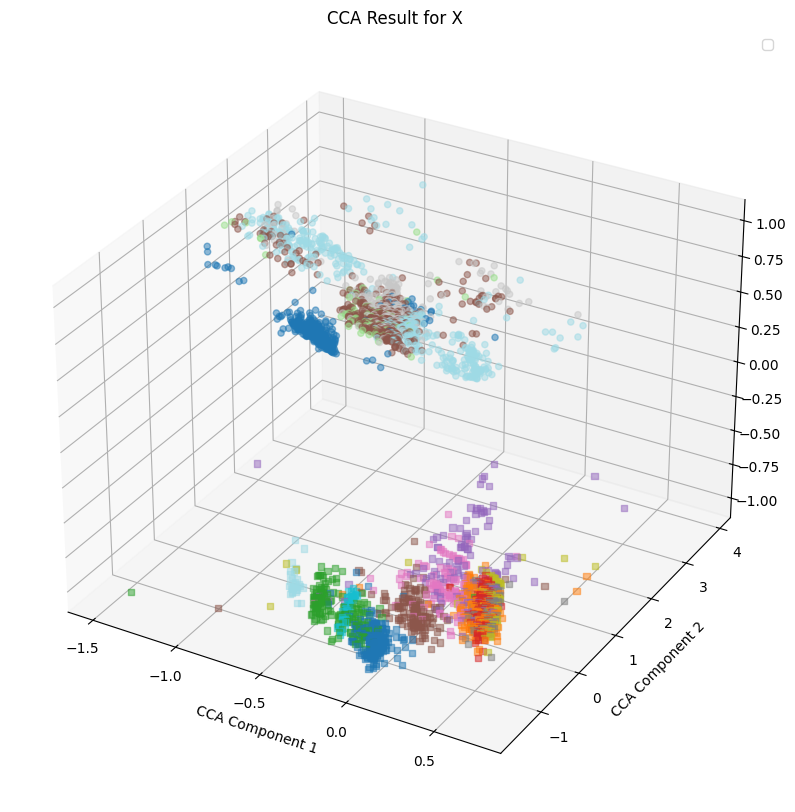

In [45]:
####select nearst neighbour of sample pairs between X1 and X3
####
print(Z_c.shape, Y_c.shape)
from scipy.spatial.distance import cdist
distances = cdist(Z_c, Y_c, metric='cosine')
dist_df = pd.DataFrame(distances)
print(dist_df.shape)
min_row_indices = dist_df.idxmin()
print(Z_c.shape, Y_c.shape)
###############找出Y_C(spatial)周围dist_min以内的Z_C(metabolic)点
Y_C_ = Y_c.iloc[:,:]
Y_C_['spatial_ID'] = Y_C_.index
Y_C_ = Y_C_.reset_index()
Y_C_["spatial_cluster"] = data2_leiden_str.astype(int)
Y_C_["spatial.CCA.Z"] = -1
Y_C_ = Y_C_.drop(columns=['index'])
Y_C_ = Y_C_.rename(columns={0: "spatial.CCA.X", 1:"spatial.CCA.Y"})
print(Z_c.shape, Y_c.shape)
Z_C_=Z_c.iloc[min_row_indices,]
Z_C_['matabolic_ID'] = Z_C_.index
Z_C_=Z_C_.reset_index()
Z_C_["matabolic_cluster"] = data1_leiden_str[min_row_indices].astype(int)
Z_C_=Z_C_.drop(columns=['index'])
Z_C_["matabolic.CCA.Z"] = 1
Z_C_=Z_C_.rename(columns={0: "metabolic.CCA.X", 1:"metabolic.CCA.Y"})
pairs = pd.concat([Y_C_,Z_C_],axis=1)
#pairs["distance"] = dist_df.iloc[row_indices,col_indices].values.diagonal()  //diagonal要求内存过大
print(pairs.head())

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(Z_c.iloc[unique_row_indices, 0], Z_c.iloc[unique_row_indices, 1],zs=1, c=data1_leiden_str[unique_row_indices].astype(int), cmap='tab20', s=20, alpha=0.5)
plt.scatter(Y_c.iloc[:, 0], Y_c.iloc[:, 1],zs=-1, c=data2_leiden_str.astype(int), cmap='tab20', s=20, alpha=0.5,marker='s')
#for i in range(0,pairs.shape[0]):
#    plt.plot(pairs.iloc[i,[0,5]], pairs.iloc[i,[1,6]], pairs.iloc[i,[4,9]], 'gray', linewidth=0.2)
plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Result for X')
plt.legend()
plt.show()

<bound method NDFrame.head of              0         1
0    -1.000000  0.310345
1    -1.000000  0.333333
2    -1.000000  0.356322
3    -1.000000  0.379310
4    -1.000000  0.402299
...        ...       ...
4125  0.976744 -0.632184
4126  0.976744 -0.609195
4127  1.000000 -0.724138
4128  1.000000 -0.701149
4129  1.000000 -0.678161

[4130 rows x 2 columns]>
<bound method NDFrame.head of              0         1
2098 -0.023256 -0.425287
1628 -0.209302  0.494253
432  -0.674419 -0.149425
646  -0.581395  0.034483
453  -0.674419  0.333333
...        ...       ...
1995 -0.069767  0.126437
1987 -0.069767 -0.057471
434  -0.674419 -0.103448
1225 -0.348837 -0.264368
3071  0.348837 -0.195402

[1366 rows x 2 columns]>


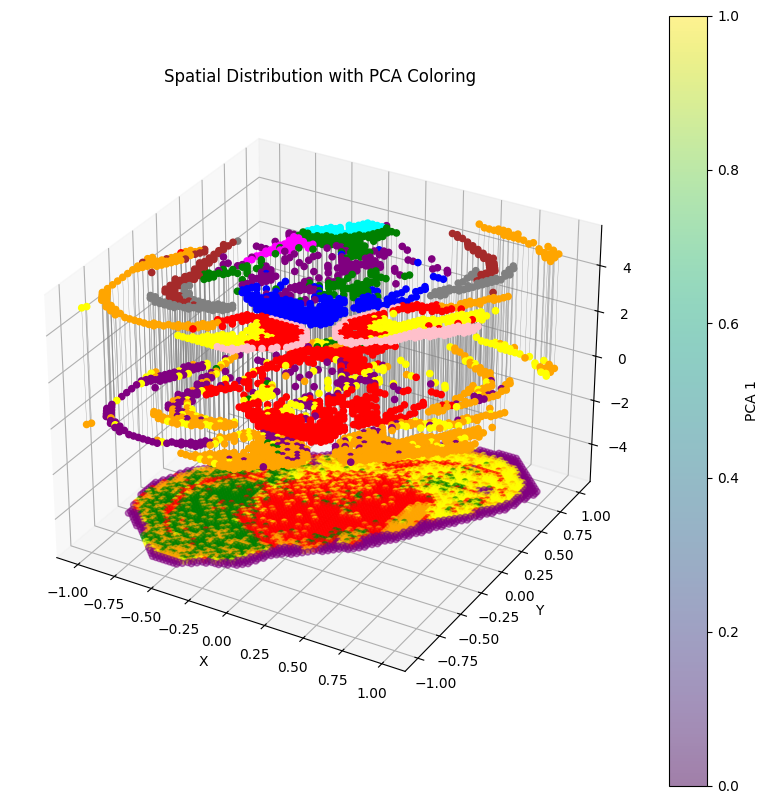

In [46]:
scaler = MinMaxScaler(feature_range=(-1, 1))

data3_spatial_results = pd.DataFrame(adata1.obsm['spatial'])
scaled_data = scaler.fit_transform(data3_spatial_results)
data3_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data3_spatial_results.head)
data1_spatial_results = data3_spatial_results.iloc[selected_indices,:]
data2_spatial_results = pd.DataFrame(adata2.obsm['spatial'])
scaled_data = scaler.fit_transform(data2_spatial_results)
data2_spatial_results = pd.DataFrame(scaled_data, columns=data3_spatial_results.columns)
print(data1_spatial_results.head)
data1_spatial_results=pd.DataFrame(data1_spatial_results)
data2_spatial_results=pd.DataFrame(data2_spatial_results)
data3_spatial_results=pd.DataFrame(data3_spatial_results)
def rotate_point_90_degrees(row):
    new_x = -row[0]
    new_y = row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(rotate_point_90_degrees, axis=1)
def flip_around_y_minus_x(row):
    new_x = -row[0]
    new_y = -row[1]
    return pd.Series({0: new_x, 1: new_y})
data3_spatial_results = data3_spatial_results.apply(flip_around_y_minus_x, axis=1)
data2_pca_results = adata2.obsm['spatial']
color_mapping = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'yellow',
    4: 'orange',
    5: 'purple',
    6: 'brown',
    7: 'pink',
    8: 'gray',
    9: 'cyan',
    10: 'magenta',
    11: 'magenta'
}

a2_pca_results = adata2.obsm['spatial']  # PCA 结果
pca_leiden = adata2.obs["leiden"]
data2_leiden_str = pca_leiden.to_numpy()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
plt.scatter(data2_spatial_results.iloc[:, 0], data2_spatial_results.iloc[:, 1], zs=5,c=[color_mapping[category] for category in data2_leiden_str.astype(int)], s=20, alpha=1)
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], zs=0,
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=0.5,zs=-5)
for i in pairs["spatial_ID"].tolist():
    plt.plot([data2_spatial_results.iloc[i, 0],data2_spatial_results.iloc[i, 0]],
            [data2_spatial_results.iloc[i, 1],data2_spatial_results.iloc[i, 1]],
             [0,5], 'gray', linewidth=0.2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()

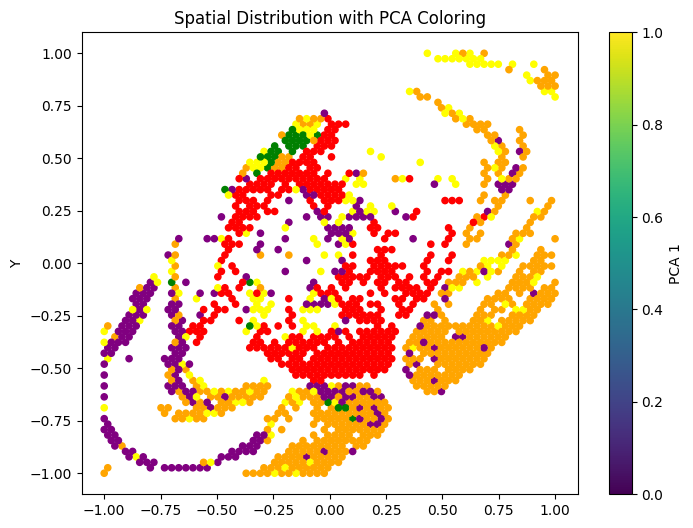

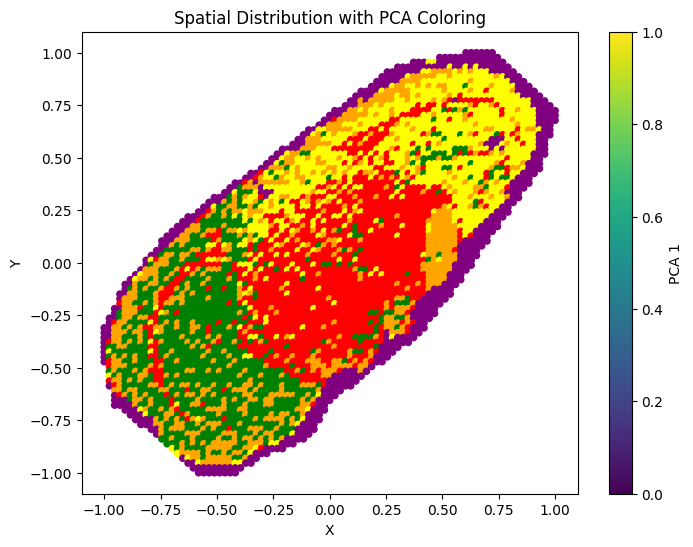

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(data2_spatial_results.iloc[:, 0],data2_spatial_results.iloc[:, 1], 
            c=[color_mapping[category] for category in pairs["matabolic_cluster"].tolist()], s=20, alpha=1)
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(data3_spatial_results.iloc[:, 0], data3_spatial_results.iloc[:, 1], c=[color_mapping[category] for category in data1_leiden_str.astype(int)], s=20, alpha=1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Spatial Distribution with PCA Coloring')
plt.colorbar(label='PCA 1')
plt.show()